In [2]:
%matplotlib

Using matplotlib backend: <object object at 0x10af72ae0>


In [3]:
import mne
from pprint import pprint
import json
import csv
import numpy as np
import pandas as pd
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from pathlib import Path

In [6]:
root_data_path = Path('/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Alice_TRF(EEG dataset_fif)/Data/eeg')
sub_idINT = 1

eeg_data_path = root_data_path / Path('S%.2d' %sub_idINT)
#print(eeg_data_path)

raw_fname = eeg_data_path / Path('S%.2d_alice-raw.fif' %sub_idINT)

raw = mne.io.read_raw_fif(raw_fname)

raw.load_data()
raw.plot()
print(raw.info)
print(raw.info["ch_names"])

Opening raw data file /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Alice_TRF(EEG dataset_fif)/Data/eeg/S01/S01_alice-raw.fif...
    Range : 0 ... 366524 =      0.000 ...   733.048 secs
Ready.
Reading 0 ... 366524  =      0.000 ...   733.048 secs...
Using qt as 2D backend.
Opening raw-browser...


qt.qpa.drawing: Layer-backing can not be explicitly controlled on 10.14 when built against the 10.14 SDK


Using pyopengl with version 3.1.6
<Info | 12 non-empty values
 bads: 7 items (22, 24, 31, 32, 36, 49, 60)
 ch_names: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...
 chs: 61 EEG, 2 Stimulus
 custom_ref_applied: True
 dig: 61 items (61 EEG)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 200.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 63
 projs: []
 sfreq: 500.0 Hz
>
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', 'VEOG', 'Aux5', '29']


In [ ]:
events = mne.find_events(raw, stim_channel='STI101')  #just checking what stim_channel documenting what.
#events = mne.find_events(raw, stim_channel='STI101', min_duration = 10 / raw.info['sfreq'])  #just checking what stim_channel documenting what.

raw.load_data().pick_types(eeg=True, stim=True).filter(0.1, 30, phase= 'zero-double').resample(250)

In [5]:
# filter and exclude certain channels
n_raw = raw.copy()
n_raw.resample(sfreq = 250)
n_raw.filter(0.1, 30, phase= 'zero-double')  # 再加0.1~30** / 1~30(訊號被扭曲的機率會更大) ，再重跑ICA
n_raw.set_eeg_reference(['M1', 'M2'])
n_raw.pick_types(eeg = True, stim = False, exclude = ['M1', 'M2', 'CB1', 'O1', 'OZ', 'O2', 'CB2', 'VEO', 'HEO', 'Audio'])
                                                     # 'VEO', 'HEO', 'Audio' >> new layouts  #'HEOG', 'VEOG'
#n_raw.plot()

# remove dc-offset

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-12 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 sec)

EEG channel type selected for re-referencing
Applying a custom EEG reference.


<RawCNT | S007_Alice_S001_new_2nd.cnt, 57 x 235680 (942.7 s), ~102.5 MB, data loaded>

Fitting ICA to data using 57 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 18.2s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 57 PCA components


/opt/anaconda3/envs/mne/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


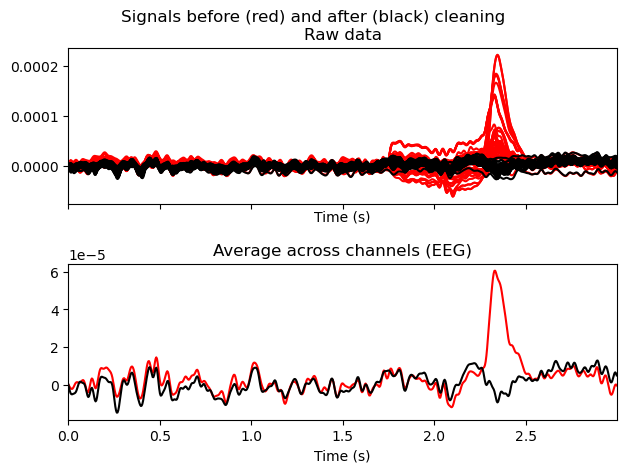

Channels marked as bad: ['Audio']


In [6]:
## WE NEED TO USE THE CUT FILE TO PERFORM ICA!!!

# set montage????? yes!!!
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
n_raw.set_montage(ten_twenty_montage, match_case=False)

# ICA
ica_ = ICA(n_components = 15, random_state=97)
ica_.fit(n_raw)

# plot ICA
#n_raw.plot_sensors(sphere = (0.0, 0.02, 0.0, 0.065))

# Exclude certain components
"""
S001:[0,5]  # DONE
S002:[0, 1, 3, 8, 10] #DONE
S003:[0,8,14] # DONE
S004-2:[0, 1, 3, 4, 6] #DONE
S005:[0, 1, 2, 8] #DONE
S006:[0,2]  #DONE >> adjust the filter range from 0-30 to 0.1-30
S007:[0,2]  #DONE >> adjust the filter range from 0-30 to 0.1-30
S008:[0,1,6,(7)]
"""

#ica_.plot_sources(n_raw)
#ica_.plot_components(sphere = (0.0, 0.02, 0.0, 0.065))  # What is this sphere for??
ica_.plot_overlay(n_raw, exclude=[0,2])

In [15]:
for i in range(15):
    #ica_.plot_properties(n_raw, picks=[i])
    ica_.plot_overlay(n_raw, exclude=[i])

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 57 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 I

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 57 PCA components


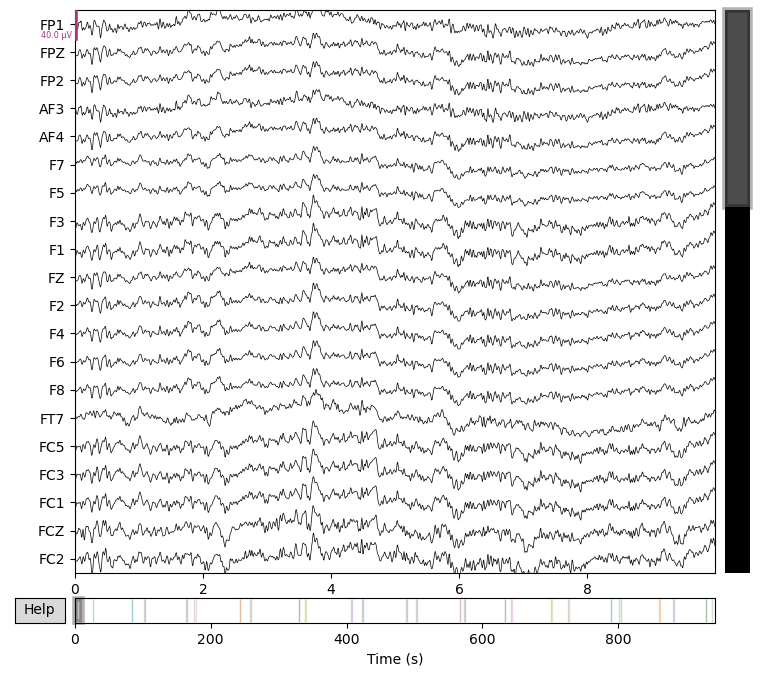

Channels marked as bad: none


In [7]:
#### What the hack is this?????

# This is the properties of each component
#ica_.plot_properties(n_raw, picks=[0, 1, 2, 3, 4, 5, 6, 7, 8])

# apply the cleaned ICA to the data 
ica_.exclude = [0,2]

raw_ICAed = n_raw.copy()
ica_.apply(raw_ICAed)
raw_ICAed.plot()

## Below are the old codes